In [137]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import re
from datetime import datetime, timedelta

dataPath = 'data/'
allBatch = pd.read_csv(dataPath + 'allBatch.csv', index_col=0).T
allBatch.reset_index(drop=False, inplace=True)
allBatch = allBatch.rename_axis(None, axis=1)
allBatch = allBatch.rename(columns={'index': 'Pre-wetting date'})

In [138]:
def column_imputer(df, cols_to_fill):
    df['Pre-wetting date'] = df['Pre-wetting date'].fillna(df['Evacuation date (B)'] - timedelta(14))
    diff_we = (df['Pre-wetting date'] - df['Evacuation date (B)']).mean()
    df['Evacuation date (B)'] = df['Evacuation date (B)'].fillna(df['Pre-wetting date'] - diff_we)
    mean = df[cols_to_fill].mean()
    df[cols_to_fill] = df[cols_to_fill].fillna(mean)
    return df

# cleaning columns
dateColumns = allBatch.columns[0:2]
percentColumns = allBatch.columns[[4, 5, 8, 11, 12]]
numericalCols = allBatch.columns[2:17]
targetColumn = ['Kg/bag (White & Brown)']
allBatch[percentColumns] = allBatch[percentColumns].apply(lambda x : x.str.strip('%').astype(float)/100)
allBatch[numericalCols] = allBatch[numericalCols].apply(pd.to_numeric, errors='coerce', downcast='float')
allBatch[targetColumn] = allBatch[targetColumn].apply(pd.to_numeric, errors='coerce', downcast='float')
allBatch[numericalCols] = allBatch[numericalCols].applymap(lambda x: re.sub("[^0-9]", "", x) if type(x) == str else x)
allBatch['Pre-wetting date'] = pd.to_datetime(allBatch['Pre-wetting date'], 
                                              format="%d-%b-%y", 
                                              errors='coerce')
allBatch['Evacuation date (B)'] = pd.to_datetime(allBatch['Evacuation date (B)'], 
                                                 format="%d-%b-%y", 
                                                 errors='coerce')
allBatch = column_imputer(allBatch, numericalCols)
futures = allBatch[allBatch['Kg/bag (White & Brown)'].isna()]
allBatch = allBatch[~allBatch['Kg/bag (White & Brown)'].isna()]


<Figure size 1650x850 with 0 Axes>

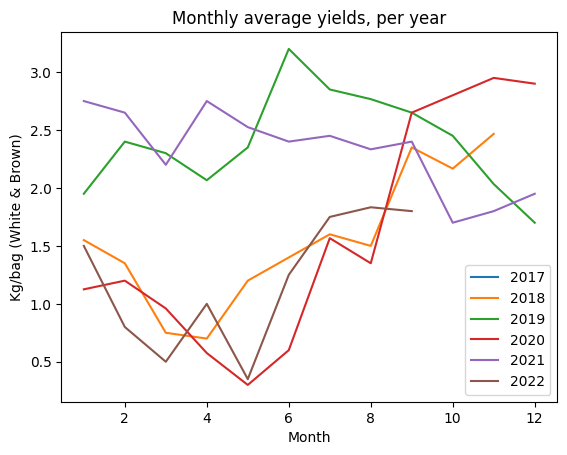

In [139]:
#EDA
allBatchData = allBatch.set_index('Pre-wetting date')
plt.style.use('default')
plt.figure().set_size_inches(16.5, 8.5)
allBatchData.groupby(allBatchData.index.month)['Kg/bag (White & Brown)'].resample('Y').mean().unstack().plot()
plt.xlabel('Month')
plt.ylabel('Kg/bag (White & Brown)')
plt.title('Monthly average yields, per year')
plt.legend(['2017', '2018', '2019', '2020', '2021', '2022'])

In [140]:
def _dateEncode(X):
    #cyclical encoding of dates
    X = X.copy()
    year_norm = 2 * np.pi * X['Pre-wetting date'].dt.year / X['Pre-wetting date'].dt.year.max()
    month_norm = 2 * np.pi * X['Pre-wetting date'].dt.month / X['Pre-wetting date'].dt.month.max()
    day_norm = 2 * np.pi * X['Pre-wetting date'].dt.day / X['Pre-wetting date'].dt.day.max()
    X.loc[:, 'year_sin'] = np.sin(year_norm)
    X.loc[:, 'year_cos'] = np.cos(year_norm)
    X.loc[:, 'month_sin'] = np.sin(month_norm)
    X.loc[:, 'month_cos'] = np.cos(month_norm)
    X.loc[:, 'day_sin'] = np.sin(day_norm)
    X.loc[:, 'day_cos'] = np.cos(day_norm)
    X.loc[:, 'year'] = X['Pre-wetting date'].dt.year
    X.loc[:, 'month'] = X['Pre-wetting date'].dt.month
    X.loc[:, 'day'] = X['Pre-wetting date'].dt.day
    return X

In [141]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer



allBatch = _dateEncode(allBatch)


y = allBatch['Kg/bag (White & Brown)']
X = allBatch[allBatch.columns[2:27]]

X_train_small, X_test_small, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)

date_encoder = FunctionTransformer(_dateEncode)
dateCols = ['day', 'month']

preprocessor = ColumnTransformer(
        [
            #('dateEncode', 'passthrough', dateCols),
            ('imputer', 'passthrough', X.columns[0:7]),
        ]
)

regressor = ExtraTreesRegressor(random_state=42)
pipe_small = make_pipeline(preprocessor, regressor)

pipe_small.fit(X_train_small, y_train)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('imputer', 'passthrough',
                                                  Index(['Wet straw at lay-out (T)', 'Dry straw at lay-out (T)',
       'Moisture content PII', 'Conversion rate', 'Fill bag rate',
       'Spawn rate (ml)', 'Compost score'],
      dtype='object'))])),
                ('extratreesregressor', ExtraTreesRegressor(random_state=42))])

In [142]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
yhat = pipe_small.predict(X_test_small)
print("Mean squared error: {}".format(mean_absolute_error(yhat, y_test)))
(yhat, y_test)

Mean squared error: 0.32207141634609016


(array([1.9       , 0.60600001, 1.83300002, 2.28100001, 2.49200003,
        1.43500001, 1.39      , 2.21400001, 2.51299995, 2.29599994,
        2.54800002, 1.82699999, 1.534     , 2.49199998]),
 130    1.4
 66     0.7
 107    2.7
 19     2.2
 42     2.9
 60     1.3
 12     1.4
 112    1.7
 103    2.4
 104    2.4
 44     2.6
 40     3.3
 27     1.6
 47     2.4
 Name: Kg/bag (White & Brown), dtype: float32)

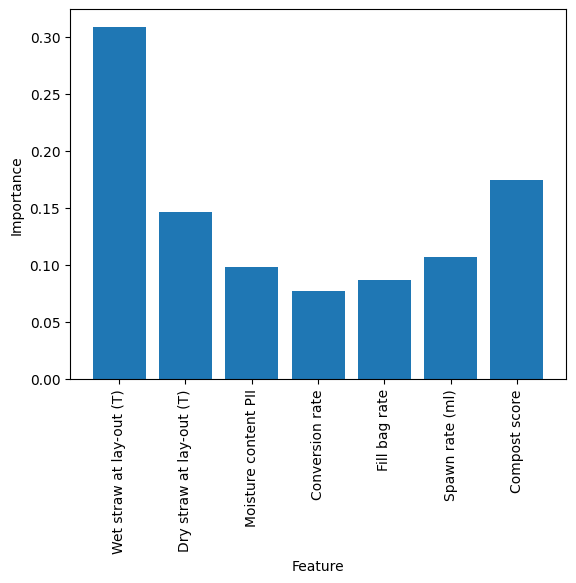

In [143]:
inputCols = X.columns[0:7].tolist() 
plt.bar(range(len(inputCols)), pipe_small.named_steps['extratreesregressor'].feature_importances_)
plt.xticks(range(len(inputCols)), inputCols, rotation='vertical')
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

In [144]:
# other meteo data with more historical
import requests
enddate = allBatch['Evacuation date (B)'].max().strftime("%Y-%m-%d")
response = requests.get('https://archive-api.open-meteo.com/v1/archive?latitude=-1.50&longitude=29.63&start_date=2018-01-13&end_date=' 
                        + enddate 
                        +'&hourly=temperature_2m,relativehumidity_2m,dewpoint_2m,surface_pressure,rain,direct_radiation,windspeed_10m,soil_temperature_0_to_7cm,soil_moisture_0_to_7cm')

In [145]:
weatherData = pd.DataFrame(response.json()['hourly'])
weatherData['time'] = pd.to_datetime(weatherData['time'], format='%Y-%m-%d')
weatherData = weatherData.groupby(weatherData.time.dt.date).agg({'temperature_2m':'mean',
                                                   'relativehumidity_2m':'mean',
                                                   'dewpoint_2m':'mean',
                                                   'surface_pressure':'mean',
                                                   'rain':'sum',
                                                   'direct_radiation':'mean',
                                                   'windspeed_10m': 'mean',
                                                   'soil_temperature_0_to_7cm':'mean',
                                                   'soil_moisture_0_to_7cm':'mean'})

In [146]:
import warnings
warnings.filterwarnings("ignore")

arr = pd.DataFrame(columns=weatherData.columns)
inputData = allBatch.loc[:, allBatch.columns[0:9]]
for i in inputData.index:
    startDate = inputData.loc[i, 'Pre-wetting date']
    endDate = inputData.loc[i, 'Evacuation date (B)']
    arr.loc[i] = weatherData.loc[startDate:endDate, :].mean()
    
df_new = pd.concat([inputData, arr], axis=1)
df_new = pd.concat([df_new, allBatch['Kg/bag (White & Brown)']], axis=1)
df_new = column_imputer(df_new, df_new.columns)

In [147]:
df_new = _dateEncode(df_new)

y = df_new['Kg/bag (White & Brown)']
X = df_new

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)

date_encoder = FunctionTransformer(_dateEncode)
dateCols = ['day', 'month']

preprocessor = ColumnTransformer(
        [
            #('dateEncode', 'passthrough', dateCols),
            ('imputer', 'passthrough', X.columns[2:18]),
        ]
)

regressor = ExtraTreesRegressor(random_state=42)
pipe = make_pipeline(preprocessor, regressor)

pipe.fit(X_train, y_train)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('imputer', 'passthrough',
                                                  Index(['Wet straw at lay-out (T)', 'Dry straw at lay-out (T)',
       'Moisture content PII', 'Conversion rate', 'Fill bag rate',
       'Spawn rate (ml)', 'Compost score', 'temperature_2m',
       'relativehumidity_2m', 'dewpoint_2m', 'surface_pressure', 'rain',
       'direct_radiation', 'windspeed_10m', 'soil_temperature_0_to_7cm',
       'soil_moisture_0_to_7cm'],
      dtype='object'))])),
                ('extratreesregressor', ExtraTreesRegressor(random_state=42))])

In [148]:
from sklearn.metrics import mean_absolute_error
yhat = pipe.predict(X_test)
print("Mean absolute error: {}".format(mean_absolute_error(yhat, y_test)))
(yhat, y_test)

Mean absolute error: 0.39092855277338207


(array([1.63700002, 0.52900001, 2.06699998, 2.53100001, 2.20000003,
        1.23100002, 1.58900001, 2.146     , 2.76399996, 2.46400001,
        2.37000002, 2.07399998, 2.27099998, 2.25799999]),
 130    1.4
 66     0.7
 107    2.7
 19     2.2
 42     2.9
 60     1.3
 12     1.4
 112    1.7
 103    2.4
 104    2.4
 44     2.6
 40     3.3
 27     1.6
 47     2.4
 Name: Kg/bag (White & Brown), dtype: float32)

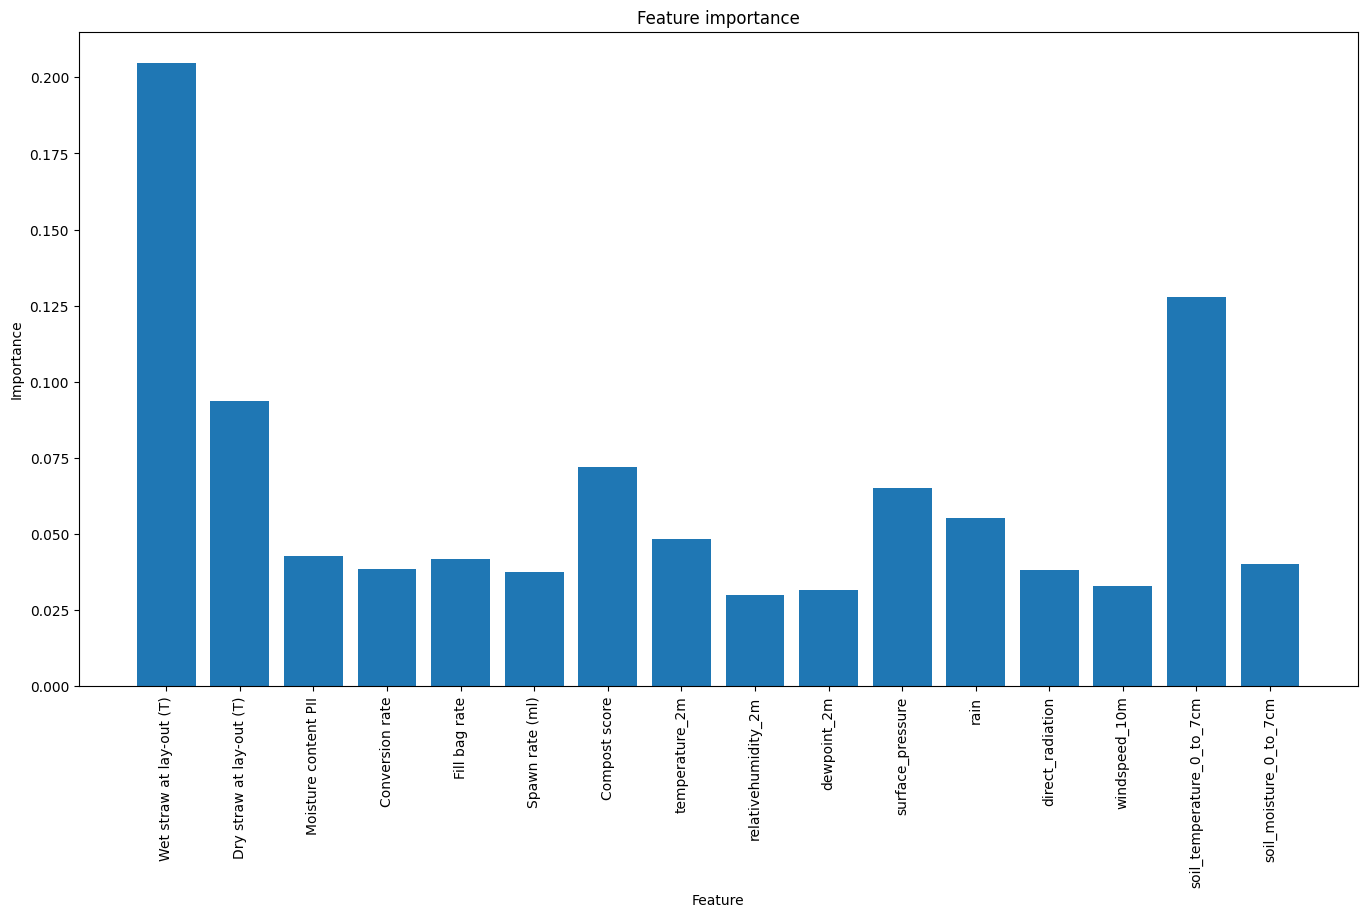

In [149]:
plt.style.use('default')
plt.figure().set_size_inches(16.5, 8.5)

inputCols = X.columns[2:18].tolist()
plt.bar(range(len(inputCols)), pipe.named_steps['extratreesregressor'].feature_importances_)
plt.title('Feature importance')
plt.xticks(range(len(inputCols)), inputCols, rotation='vertical')
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

In [150]:
import statsmodels.api as sm
import numpy as np
Y_ols = df_new['Kg/bag (White & Brown)']
X_ols = df_new[X.columns[2:9]]
X_ols = sm.add_constant(X_ols)
model = sm.OLS(Y_ols, X_ols)
results = model.fit()
print(results.summary())

                              OLS Regression Results                              
Dep. Variable:     Kg/bag (White & Brown)   R-squared:                       0.212
Model:                                OLS   Adj. R-squared:                  0.168
Method:                     Least Squares   F-statistic:                     4.830
Date:                    Wed, 25 Jan 2023   Prob (F-statistic):           7.60e-05
Time:                            20:16:47   Log-Likelihood:                -148.17
No. Observations:                     134   AIC:                             312.3
Df Residuals:                         126   BIC:                             335.5
Df Model:                               7                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

Text(0.5, 1.0, 'Predictions vs. True Values')

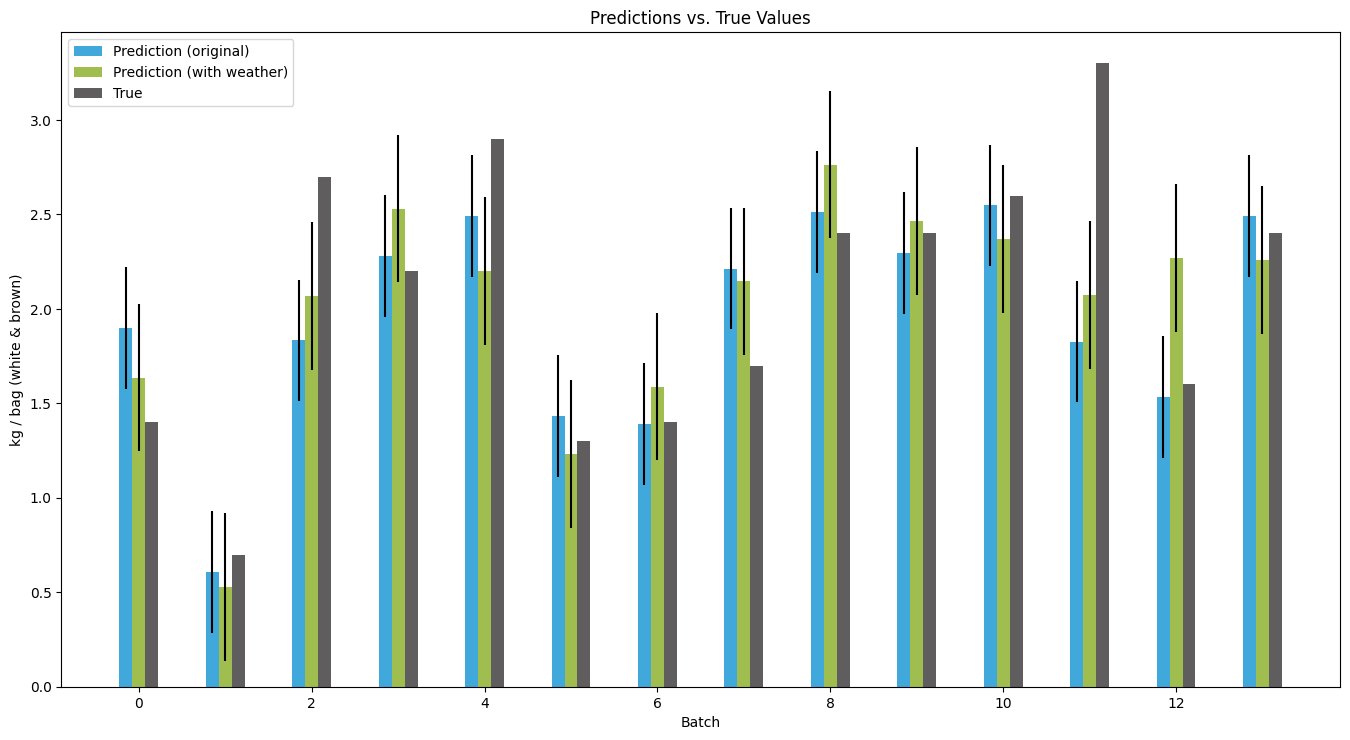

In [153]:
# Comparing models
plt.style.use('default')
plt.figure().set_size_inches(16.5, 8.5)
yhat_small = pipe_small.predict(X_test_small)
yhat = pipe.predict(X_test)
width = 0.15

# Plot the first group of bars (yhat_small) at x-coordinates 0, 1, 2, etc.
plt.bar(np.arange(len(y_test)) - width, yhat_small, width, label='Prediction (original)', yerr=mean_absolute_error(y_test, yhat_small), color='#40a8db')
plt.bar(np.arange(len(y_test)), yhat, width, label='Prediction (with weather)', yerr=mean_absolute_error(y_test, yhat), color='#a0bd50')
plt.bar(np.arange(len(y_test)) + width, y_test, width, label='True', color='#5f5d5e')
plt.legend()
plt.xlabel('Batch')
plt.ylabel('kg / bag (white & brown)')
plt.title('Predictions vs. True Values')

In [127]:
## ols regression of data and interpreting model further

import statsmodels.api as sm
import numpy as np
Y_ols = df_new['Kg/bag (White & Brown)']
X_ols = df_new[X.columns[2:18]]
X_ols = sm.add_constant(X_ols)
model = sm.OLS(Y_ols, X_ols)
results = model.fit()
print(results.summary())


                              OLS Regression Results                              
Dep. Variable:     Kg/bag (White & Brown)   R-squared:                       0.460
Model:                                OLS   Adj. R-squared:                  0.387
Method:                     Least Squares   F-statistic:                     6.241
Date:                    Wed, 25 Jan 2023   Prob (F-statistic):           7.86e-10
Time:                            17:21:26   Log-Likelihood:                -122.76
No. Observations:                     134   AIC:                             279.5
Df Residuals:                         117   BIC:                             328.8
Df Model:                              16                                         
Covariance Type:                nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [128]:
arr = pd.DataFrame(columns=weatherData.columns)
inputData = futures.loc[137:142, allBatch.columns[0:9]]
for i in inputData.index:
    startDate = inputData.loc[i, 'Pre-wetting date']
    endDate = inputData.loc[i, 'Evacuation date (B)']
    arr.loc[i] = weatherData.loc[startDate:endDate, :].mean()
    
future_batch = pd.concat([inputData, arr], axis=1)
future_batch = column_imputer(future_batch, future_batch.columns)

In [131]:
pipe_small.predict(_dateEncode(future_batch))

array([1.69299998, 1.864     , 1.57      , 1.849     , 1.151     ,
       0.93300001])

In [130]:
future_batch

,Pre-wetting date,Evacuation date (B),Wet straw at lay-out (T),Dry straw at lay-out (T),Moisture content PII,Conversion rate,Fill bag rate,Spawn rate (ml),Compost score,temperature_2m,relativehumidity_2m,dewpoint_2m,surface_pressure,rain,direct_radiation,windspeed_10m,soil_temperature_0_to_7cm,soil_moisture_0_to_7cm
137,2022-09-26,2022-12-24 08:49:24.705882353,20.0,17.0,0.690000,0.720000,14.500000,125.000000,0.70959,24.623575,78.453947,20.220559,836.734101,4.727632,137.471491,5.318640,19.045779,0.394243
138,2022-10-10,2023-01-07 08:49:24.705882353,16.0,13.6,0.670000,0.760000,14.500000,125.000000,0.70959,24.477957,79.760753,20.370565,836.722177,5.377419,130.434812,5.083468,18.979637,0.398061
139,2022-10-24,2023-01-21 08:49:24.705882353,16.0,13.6,0.700000,0.750000,14.500000,125.000000,0.70959,24.219010,81.705729,20.588542,836.581424,5.962500,123.037326,4.938194,18.828038,0.403374
140,2022-11-07,2023-02-04 08:49:24.705882353,16.0,13.6,0.670000,0.770000,14.500000,125.000000,0.70959,23.776961,84.001225,20.689338,836.551716,7.564706,114.966912,4.643015,18.453676,0.415817
141,2022-11-23,2023-02-20 08:49:24.705882353,10.0,8.5,0.700000,0.760000,16.000000,133.000000,0.70959,23.905787,82.067130,20.390972,835.794444,4.666667,136.041667,5.048380,18.249306,0.410995
142,2022-11-30,2023-02-27 08:49:24.705882353,10.0,8.7,0.694824,0.770063,14.742958,125.922535,0.70959,23.738636,83.117424,20.418182,835.917424,5.318182,137.617424,4.979545,18.148106,0.410023
